In [25]:
#import pyodbc
import pandas as pd
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import math

In [26]:
def J_joshi(kh,h,mu,bo,l, re, rw, kvkh, s):
    a = (l/2) * np.sqrt(0.5 + np.sqrt(0.25 +(2*re/l)**4))
    r = (a + np.sqrt(a**2- (l/2)**2))/(l/2)
    b = np.sqrt(1/kvkh)
    den = mu*bo*(np.log(r)+ ((b**2)*h/l)*np.log(h/(2*rw)))
    j = 0.0078*h*kh/(den)
    return j

def arps(t, b_factor, initial_rate, decline):
    if b_factor == 0:
        values = initial_rate * np.exp(-decline * t)
    else:
        values = initial_rate / ((1 + b_factor * decline * t) ** (1 / b_factor))
    return values

def arps_reserves(initial_rate, b_factor, decline, abandonment):
    eur = initial_rate / (decline * (1 - b_factor)) * (1 - (abandonment / initial_rate) ** (1 - b_factor))
    return eur

In [27]:
kh = 20
h = 100
bo = 1.1
mu = 0.9
kvkh = 0.1
re = 600
s=-1
l=5000
DP = 500
rw = 0.33

j =J_joshi(kh,h,mu,bo,l, re, rw, kvkh, s)
q = j*DP
print(q)




7421.543056946136


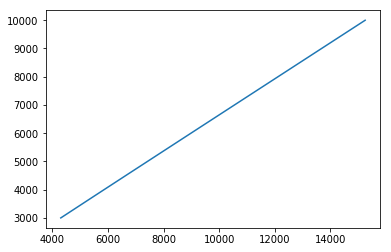

In [28]:
wells_length = np.linspace(3000, 10000, 10)
q = J_joshi(kh,h,mu,bo,wells_length, re, rw, kvkh, s)*DP
plt.plot(q,wells_length)

In [41]:
sampling_size = 10000
binning = 10

[19.56923918 13.8643719  16.86550573 ... 11.84874154 22.7681582
 30.00726268]


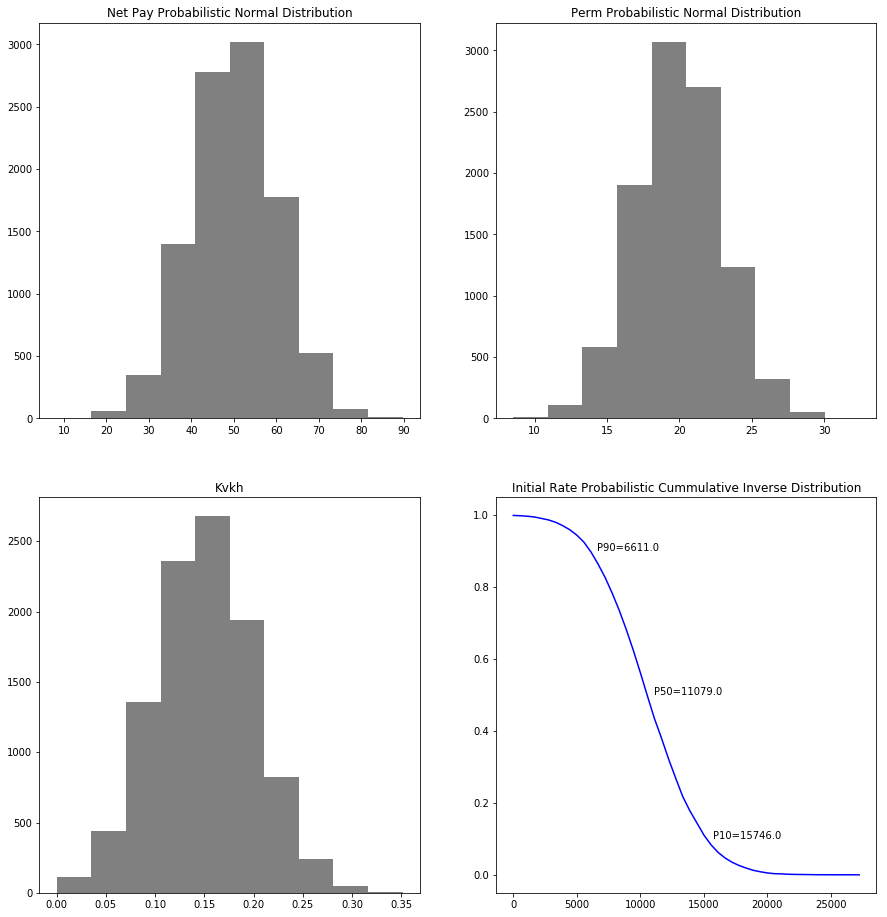

In [42]:
l=5000
re=600


h = stats.norm.rvs(size=sampling_size,loc=50,scale=10)   
h= np.array(h)
h[h<=0]=0.0001

kvkh = stats.norm.rvs(size=sampling_size,loc=0.15,scale=0.05)   
kvkh= np.array(kvkh)
kvkh[kvkh<=0]=0.0001

kh = stats.norm.rvs(size=sampling_size,loc=20,scale=3)   
kh= np.array(kh)
kh[kh<=0]=0.0001

j =J_joshi(kh,h,mu,bo,l, re, rw, kvkh, s)

j= np.array(j)
print(j)
q = j*DP
q= np.array(q)

P10=np.percentile(q,90)
P50=np.percentile(q,50)
P90=np.percentile(q,10)

plt.figure(figsize=(15,16))
plt.subplot(2,2,1)   
plt.hist(h, bins=binning, color='grey')
plt.title('Net Pay Probabilistic Normal Distribution')


plt.subplot(2,2,2)   
plt.hist(kh, bins=binning, color='grey')
plt.title('Perm Probabilistic Normal Distribution')

plt.subplot(2,2,3)   
plt.hist(kvkh, bins=binning, color='grey')
plt.title('Kvkh')

values, base = np.histogram(q, bins=50)
cumulative = np.cumsum(values)
cum_max = np.amax(cumulative)
plt.subplot(2,2,4)
plt.title('Initial Rate Probabilistic Cummulative Inverse Distribution')
plt.annotate('P90=' + str(round(P90,0)) ,xy=(P90,0.9))
plt.annotate('P50=' + str(round(P50,0)),xy=(P50,0.5))
plt.annotate('P10=' + str(round(P10,0)),xy=(P10,0.1))
plt.plot(base[:-1],(len(q)- cumulative)/cum_max, c='blue')

In [43]:
t = np.linspace(1,10000,100)
count = 0 
MC_iter = 10000

initial_rate = q
ab_rate=100

b_factor = 0.5
decline_vals = stats.norm.rvs(loc=0.0009, scale=0.00001, 
                              size=sampling_size, random_state=None)
decline_vals[decline_vals<0]=0.00001

#b_factor_vals=np.array(b_factor_vals)
#decline_vals=np.array(decline_vals)

eur = arps_reserves(initial_rate, b_factor,decline_vals, ab_rate)

#for i in range(MC_iter):
#    q = arps(t, b_factor_vals[i], initial_rate, decline_vals[i])
#    plt.plot(t, q, '-', color='grey', alpha=0.3)
P10=np.percentile(eur,90)
P50=np.percentile(eur,50)
P90=np.percentile(eur,10)



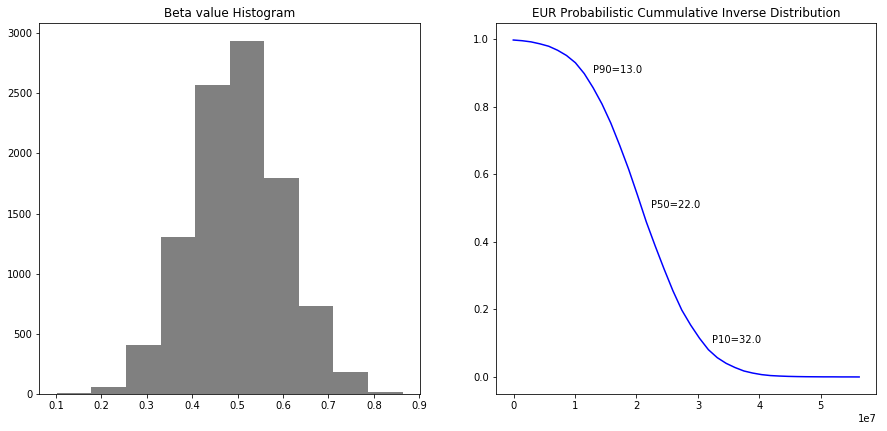

In [44]:
plt.figure(figsize=(15,15))
plt.subplot(2,2,1) 
plt.title('Beta value Histogram')
plt.hist(b_factor_vals, bins=binning, color='grey')

values, base = np.histogram(eur, bins=40)
cumulative = np.cumsum(values)
cum_max = np.amax(cumulative)
plt.subplot(2,2,2)
plt.plot(base[:-1], (len(eur)-cumulative)/cum_max, c='blue')
plt.title('EUR Probabilistic Cummulative Inverse Distribution')
plt.annotate('P90=' + str(round(P90/1000000,0)) ,xy=(P90,0.9))
plt.annotate('P50=' + str(round(P50/1000000,0)),xy=(P50,0.5))
plt.annotate('P10=' + str(round(P10/1000000,0)),xy=(P10,0.1))
plt.show()